# Bengaluru House Data Analysis




#### Step 1: Importing Required Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look nicer
sns.set_theme(style="whitegrid")



#### Step 2: Loading the Dataset
We will load the **Bengaluru_House_Data_Sample.csv** file and preview its contents.


In [3]:
# Load dataset (sample of 800 rows)
df = pd.read_csv("../Bengaluru_House_Data_Sample.csv")

# Preview first 5 rows
df.head()


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Built-up Area,Ready To Move,Banjara Layout,2 Bedroom,NaN,1050,2.0,1.0,64.8
1,Super built-up Area,Ready To Move,Rajiv Nagar,3 BHK,PuoodSk,1690,3.0,1.0,125.0
2,Built-up Area,Ready To Move,Hebbal,2 BHK,NaN,1100,2.0,1.0,60.0
3,Plot Area,Ready To Move,Munnekollal,6 Bedroom,NaN,1200,4.0,2.0,110.0
4,Built-up Area,18-Apr,Choodasandra,4 Bedroom,LGifeew,2429,3.0,1.0,210.0


#### Step 3: Dataset Overview



In [4]:
# Shape of dataset (rows, columns)
df.shape


(800, 9)

In [5]:
# Data types of each column
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     800 non-null    object 
 1   availability  800 non-null    object 
 2   location      800 non-null    object 
 3   size          799 non-null    object 
 4   society       489 non-null    object 
 5   total_sqft    800 non-null    object 
 6   bath          797 non-null    float64
 7   balcony       767 non-null    float64
 8   price         800 non-null    float64
dtypes: float64(3), object(6)
memory usage: 56.4+ KB


In [6]:
# Summary statistics for numeric columns
df.describe()


,bath,balcony,price
count,797.000000,767.000000,800.000000
mean,2.642409,1.552803,108.366356
std,1.194147,0.815653,140.492347
min,1.000000,0.000000,8.440000
25%,2.000000,1.000000,49.000000
50%,2.000000,2.000000,69.000000
75%,3.000000,2.000000,115.000000
max,10.000000,3.000000,2800.000000


In [7]:
# Missing values in each column
df.isnull().sum()


area_type         0
availability      0
location          0
size              1
society         311
total_sqft        0
bath              3
balcony          33
price             0
dtype: int64

#### Step 4: Data Cleaning

In [8]:
##Convert size → numeric bhk

def extract_bhk(x):
    try:
        return int(x.split(' ')[0])  # e.g., "2 BHK" -> 2
    except:
        return None

df['bhk'] = df['size'].apply(extract_bhk)

df[['size','bhk']].head(10)


,size,bhk
0,2 Bedroom,2.0
1,3 BHK,3.0
2,2 BHK,2.0
3,6 Bedroom,6.0
4,4 Bedroom,4.0
5,3 BHK,3.0
6,2 BHK,2.0
7,2 BHK,2.0
8,3 BHK,3.0
9,2 BHK,2.0


In [9]:
##Convert total_sqft → numeric

def convert_sqft(x):
    try:
        # Case 1: Range (e.g., "1200 - 1500")
        if '-' in str(x):
            tokens = x.split('-')
            if len(tokens) == 2:
                return (float(tokens[0]) + float(tokens[1])) / 2

        # Case 2: Units conversion
        if 'Sq. Meter' in str(x):
            return float(x.split('Sq. Meter')[0]) * 10.7639
        if 'Sq. Yards' in str(x):
            return float(x.split('Sq. Yards')[0]) * 9
        if 'Perch' in str(x):
            return float(x.split('Perch')[0]) * 272.25
        if 'Acres' in str(x):
            return float(x.split('Acres')[0]) * 43560

        # Case 3: Simple number
        return float(x)
    except:
        return None

df['total_sqft_num'] = df['total_sqft'].apply(convert_sqft)

df[['total_sqft','total_sqft_num']].head(10)


,total_sqft,total_sqft_num
0,1050,1050.0
1,1690,1690.0
2,1100,1100.0
3,1200,1200.0
4,2429,2429.0
5,1325,1325.0
6,1250,1250.0
7,700,700.0
8,1650,1650.0
9,1208,1208.0


In [10]:
##Price is in lakhs, so convert to rupees first.

df['price_in_rupees'] = df['price'] * 100000
df['price_per_sqft'] = df['price_in_rupees'] / df['total_sqft_num']

df[['price','total_sqft_num','price_in_rupees','price_per_sqft']].head(10)


,price,total_sqft_num,price_in_rupees,price_per_sqft
0,64.8,1050.0,6480000.0,6171.428571
1,125.0,1690.0,12500000.0,7396.449704
2,60.0,1100.0,6000000.0,5454.545455
3,110.0,1200.0,11000000.0,9166.666667
4,210.0,2429.0,21000000.0,8645.533141
5,90.0,1325.0,9000000.0,6792.452830
6,65.0,1250.0,6500000.0,5200.000000
7,35.0,700.0,3500000.0,5000.000000
8,48.0,1650.0,4800000.0,2909.090909
9,49.0,1208.0,4900000.0,4056.291391


In [11]:
##Handle Missing & Outliers

# Drop rows where total_sqft_num is missing
df = df.dropna(subset=['total_sqft_num'])

# Remove absurd bhk values (>20)
df = df[df['bhk'] < 20]

# Remove price_per_sqft outliers (keep only 1st–99th percentile)
lower, upper = df['price_per_sqft'].quantile([0.01, 0.99])
df = df[(df['price_per_sqft'] >= lower) & (df['price_per_sqft'] <= upper)]

df.shape


(783, 13)

#### Step 5: Exploratory Data Analysis (EDA)


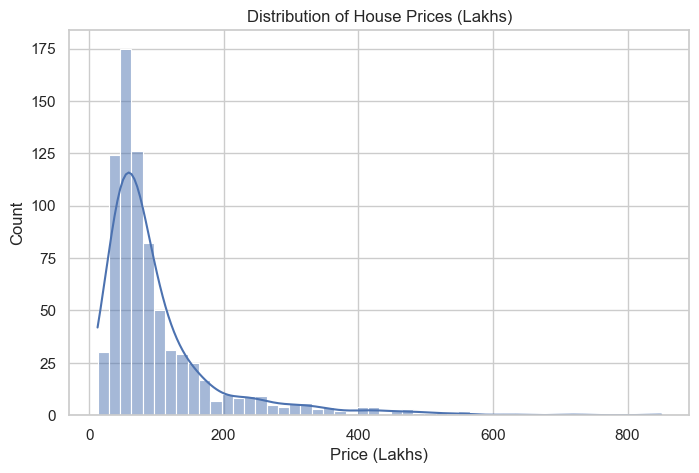

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Distribution of House Prices (Lakhs)")
plt.xlabel("Price (Lakhs)")
plt.ylabel("Count")
plt.show()


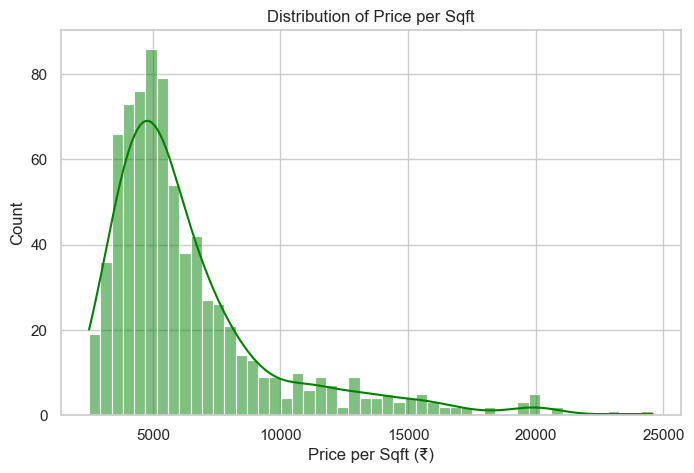

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(df['price_per_sqft'], bins=50, kde=True, color="green")
plt.title("Distribution of Price per Sqft")
plt.xlabel("Price per Sqft (₹)")
plt.ylabel("Count")
plt.show()


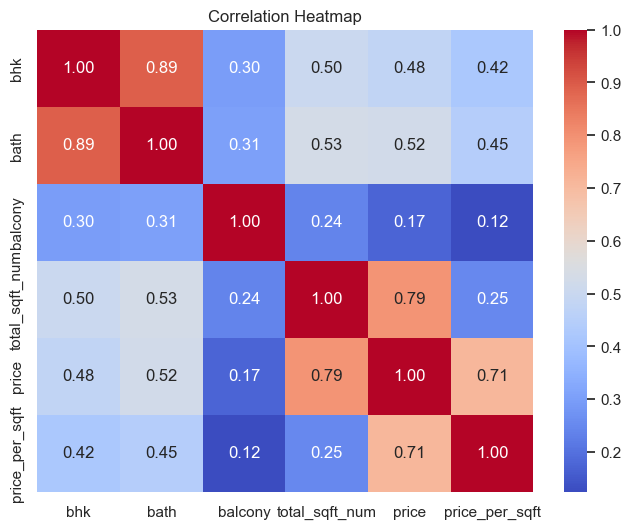

In [14]:
plt.figure(figsize=(8,6))
corr = df[['bhk','bath','balcony','total_sqft_num','price','price_per_sqft']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


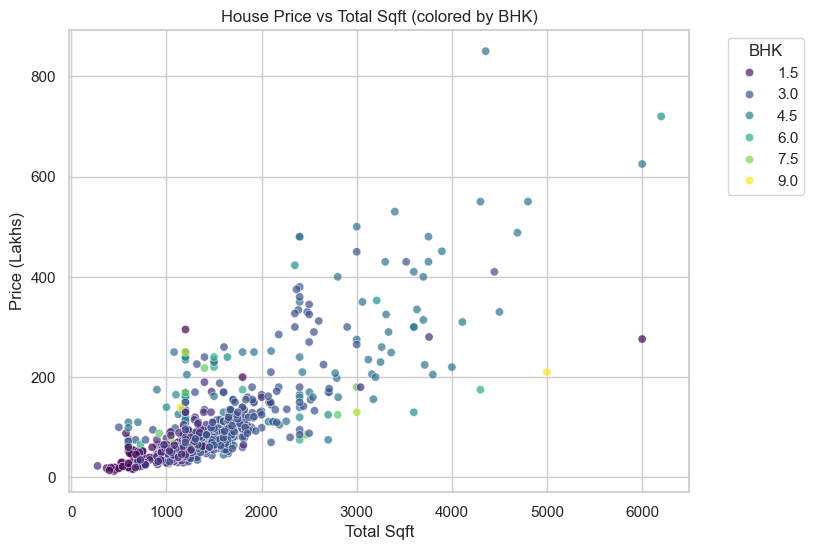

In [16]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='total_sqft_num', y='price', hue='bhk', data=df, palette="viridis", alpha=0.7)
plt.title("House Price vs Total Sqft (colored by BHK)")
plt.xlabel("Total Sqft")
plt.ylabel("Price (Lakhs)")
plt.legend(title="BHK", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


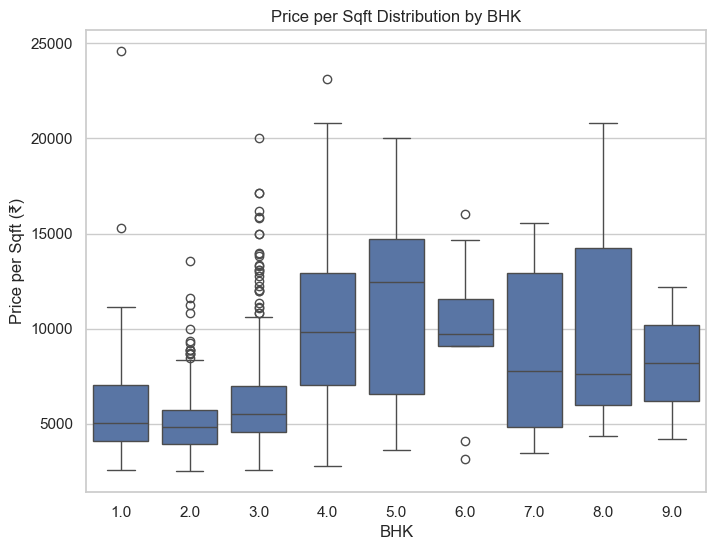

In [17]:
plt.figure(figsize=(8,6))
sns.boxplot(x='bhk', y='price_per_sqft', data=df)
plt.title("Price per Sqft Distribution by BHK")
plt.xlabel("BHK")
plt.ylabel("Price per Sqft (₹)")
plt.show()
